In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")


In [ ]:
# excel_file = "Q1 2025 Interim Management Statement.xlsx"

# Look at what sheets exist in the workbook
#xl = pd.ExcelFile(excel_file)
#xl.sheet_names


['2.1 brand_revenues.csv',
 '2.2 revenue_by_geography.csv',
 '2.3 revenue_by_channel.csv',
 '2.4 store_network.csv',
 'Q1 2025 Interim Management Stat']

In [ ]:
# === LOAD DATA FROM EXCEL ===

# excel_file = "Q1 2025 Interim Management Statement.xlsx"

#df_brand   = pd.read_excel(excel_file, sheet_name="2.1 brand_revenues.csv")
#df_region  = pd.read_excel(excel_file, sheet_name="2.2 revenue_by_geography.csv")
#df_channel = pd.read_excel(excel_file, sheet_name="2.3 revenue_by_channel.csv")
#df_store   = pd.read_excel(excel_file, sheet_name="2.4 store_network.csv")

#for name, df in [("BRAND", df_brand), ("REGION", df_region),
                 #("CHANNEL", df_channel), ("STORE", df_store)]:
    #print(f"===== {name} =====")
    #print(df.head(), "\n")


===== BRAND =====
   year quarter         brand  revenue_eur_m  yoy_pct
0  2024      Q1         Group          818.0      NaN
1  2025      Q1         Group          829.0      1.0
2  2024      Q1       Moncler          705.0      NaN
3  2025      Q1       Moncler          721.8      2.0
4  2024      Q1  Stone Island          113.0      NaN 

===== REGION =====
   year quarter    brand    region  revenue_eur_m
0  2024      Q1  Moncler      Asia          362.6
1  2024      Q1  Moncler      EMEA          245.9
2  2024      Q1  Moncler  Americas           96.4
3  2025      Q1  Moncler      Asia          380.8
4  2025      Q1  Moncler      EMEA          244.3 

===== CHANNEL =====
   year quarter         brand    channel  revenue_eur_m
0  2024      Q1       Moncler        DTC          608.5
1  2024      Q1       Moncler  Wholesale           96.5
2  2025      Q1       Moncler        DTC          630.5
3  2025      Q1       Moncler  Wholesale           91.3
4  2024      Q1  Stone Island      

In [4]:
# === BASIC CLEANING ===

for df in [df_brand, df_region, df_channel, df_store]:
    df.columns = df.columns.str.strip().str.lower()

# Try to coerce numeric columns
for df in [df_brand, df_region, df_channel]:
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    if "revenue_eur_m" in df.columns:
        df["revenue_eur_m"] = pd.to_numeric(df["revenue_eur_m"], errors="coerce")

# helper: convert year + quarter to numeric time for regression (2024 Q1 = 2024.0, 2025 Q1 = 2025.0, etc.)
def quarter_to_num(row):
    q = row.get("quarter")
    if isinstance(q, str) and q.upper().startswith("Q"):
        q_num = int(q[1])
    else:
        q_num = 1
    return float(row["year"]) + (q_num - 1) / 4

for df in [df_brand, df_region, df_channel]:
    if "quarter" in df.columns:
        df["time_num"] = df.apply(quarter_to_num, axis=1)

df_brand.head()


,year,quarter,brand,revenue_eur_m,yoy_pct,time_num
0,2024,Q1,Group,818.0,NaN,2024.0
1,2025,Q1,Group,829.0,1.0,2025.0
2,2024,Q1,Moncler,705.0,NaN,2024.0
3,2025,Q1,Moncler,721.8,2.0,2025.0
4,2024,Q1,Stone Island,113.0,NaN,2024.0


region
Asia        412.0
EMEA        313.7
Americas    103.3
Name: revenue_eur_m, dtype: float64

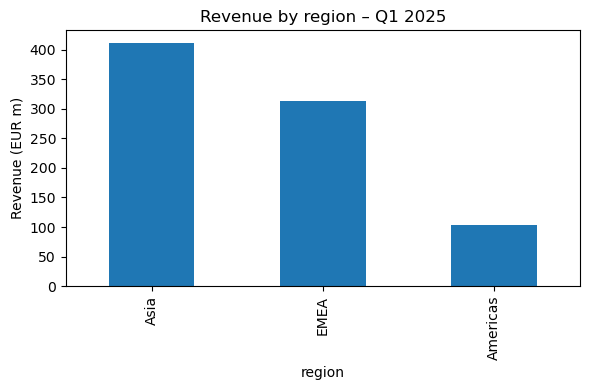

channel
DTC          685.8
Wholesale    143.3
Name: revenue_eur_m, dtype: float64

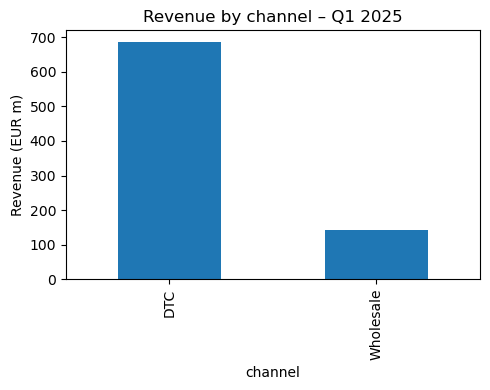

In [5]:
# === DESCRIPTIVE: REVENUE BY REGION, LATEST QUARTER ===

latest_year = df_region["year"].max()
latest_q    = df_region.loc[df_region["year"] == latest_year, "quarter"].mode()[0]

mask_latest_reg = (df_region["year"] == latest_year) & (df_region["quarter"] == latest_q)
region_latest = (df_region[mask_latest_reg]
                 .groupby("region")["revenue_eur_m"]
                 .sum()
                 .sort_values(ascending=False))

display(region_latest)

plt.figure(figsize=(6,4))
region_latest.plot(kind="bar")
plt.ylabel("Revenue (EUR m)")
plt.title(f"Revenue by region – {latest_q} {latest_year}")
plt.tight_layout()
plt.show()


# === DESCRIPTIVE: REVENUE BY CHANNEL, LATEST QUARTER ===

mask_latest_ch = (df_channel["year"] == latest_year) & (df_channel["quarter"] == latest_q)
channel_latest = (df_channel[mask_latest_ch]
                  .groupby("channel")["revenue_eur_m"]
                  .sum()
                  .sort_values(ascending=False))

display(channel_latest)

plt.figure(figsize=(5,4))
channel_latest.plot(kind="bar")
plt.ylabel("Revenue (EUR m)")
plt.title(f"Revenue by channel – {latest_q} {latest_year}")
plt.tight_layout()
plt.show()


df_channel columns: ['year', 'quarter', 'brand', 'channel', 'revenue_eur_m', 'time_num']
No 'region' column found – using TOTAL + CHANNEL diagnostic


,year,DTC,WHOLESALE,total,dtc_share,yoy_growth
0,2024,657.9,160.1,818.0,0.804279,NaN
1,2025,685.8,143.3,829.1,0.827162,0.01357



Correlation between DTC share and YoY growth:
            dtc_share  yoy_growth
dtc_share         1.0         NaN
yoy_growth        NaN         NaN


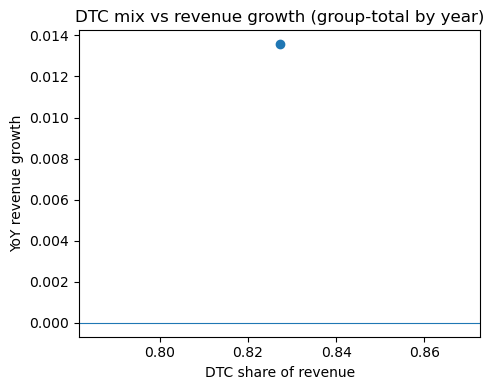

In [7]:
# === DIAGNOSTIC: DTC SHARE VS YoY GROWTH (ADAPTIVE VERSION) ===

# Work from the cleaned df_channel
print("df_channel columns:", df_channel.columns.tolist())

# Try to detect region column if it exists
has_region = "region" in df_channel.columns

if has_region:
    print("Using REGION + CHANNEL diagnostic")

    region_channel = (
        df_channel
        .groupby(["year", "region", "channel"])["revenue_eur_m"]
        .sum()
        .reset_index()
    )

    pivot_rc = region_channel.pivot_table(
        index=["year", "region"],
        columns="channel",
        values="revenue_eur_m",
        aggfunc="sum"
    ).fillna(0)

else:
    print("No 'region' column found – using TOTAL + CHANNEL diagnostic")

    # aggregate only by year and channel
    region_channel = (
        df_channel
        .groupby(["year", "channel"])["revenue_eur_m"]
        .sum()
        .reset_index()
    )

    pivot_rc = region_channel.pivot_table(
        index=["year"],
        columns="channel",
        values="revenue_eur_m",
        aggfunc="sum"
    ).fillna(0)

# normalise channel names and compute DTC share
pivot_rc.columns = [str(c).upper() for c in pivot_rc.columns]

pivot_rc["total"] = pivot_rc.sum(axis=1)
pivot_rc["dtc_share"] = pivot_rc.filter(like="DTC").sum(axis=1) / pivot_rc["total"]

# sort time properly and compute YoY growth on total
pivot_rc = pivot_rc.reset_index().sort_values("year")
pivot_rc["yoy_growth"] = pivot_rc["total"].pct_change()

display(pivot_rc)

print("\nCorrelation between DTC share and YoY growth:")
print(pivot_rc[["dtc_share", "yoy_growth"]].corr())

# scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(pivot_rc["dtc_share"], pivot_rc["yoy_growth"])
plt.xlabel("DTC share of revenue")
plt.ylabel("YoY revenue growth")
title_suffix = "by region-year" if has_region else "group-total by year"
plt.title(f"DTC mix vs revenue growth ({title_suffix})")
plt.axhline(0, linewidth=0.8)
plt.tight_layout()
plt.show()


df_geo columns: ['year', 'quarter', 'brand', 'region', 'revenue_eur_m']


,year,region,revenue_eur_m
0,2024,Americas,104.4
1,2024,Asia,390.0
2,2024,EMEA,323.6
3,2025,Americas,103.3
4,2025,Asia,412.0
5,2025,EMEA,313.7



YoY growth by region:


,year,region,revenue_eur_m,yoy_growth
0,2024,Americas,104.4,NaN
3,2025,Americas,103.3,-0.010536
1,2024,Asia,390.0,NaN
4,2025,Asia,412.0,0.056410
2,2024,EMEA,323.6,NaN
5,2025,EMEA,313.7,-0.030593



Regional growth contributions 2025 vs 2024:


,rev_2024,rev_2025,share_2024,growth,growth_contribution
region,,,,,
Asia,390.0,412.0,0.476773,0.056410,0.026895
Americas,104.4,103.3,0.127628,-0.010536,-0.001345
EMEA,323.6,313.7,0.395599,-0.030593,-0.012103


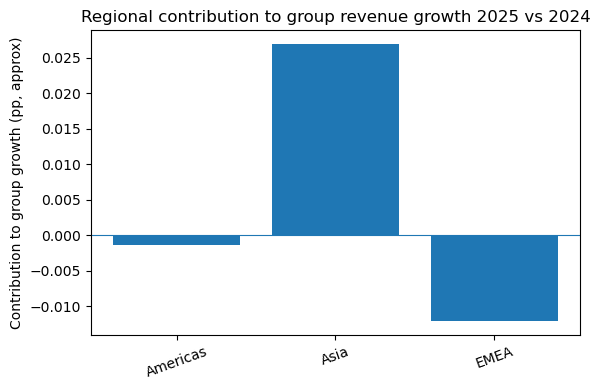

In [10]:
# === DIAGNOSTIC 2: REGIONAL GROWTH CONTRIBUTION ===
# Uses df_geo from sheet '2.2 revenue_by_geography.csv'

print("df_geo columns:", df_geo.columns.tolist())

# 1) Aggregate by year and region
geo_reg = (
    df_geo
    .groupby(["year", "region"])["revenue_eur_m"]
    .sum()
    .reset_index()
)

display(geo_reg)

# 2) Compute YoY growth by region
geo_reg = geo_reg.sort_values(["region", "year"])
geo_reg["yoy_growth"] = (
    geo_reg
    .groupby("region")["revenue_eur_m"]
    .pct_change()
)

print("\nYoY growth by region:")
display(geo_reg)

# 3) Focus on the latest year (2025 vs 2024) and compute growth contribution
base_year = 2024
curr_year = 2025

geo_24 = geo_reg[geo_reg["year"] == base_year].set_index("region")
geo_25 = geo_reg[geo_reg["year"] == curr_year].set_index("region")

# Align regions that exist in both years
common_regions = geo_24.index.intersection(geo_25.index)
tmp = pd.DataFrame({
    "rev_2024": geo_24.loc[common_regions, "revenue_eur_m"],
    "rev_2025": geo_25.loc[common_regions, "revenue_eur_m"],
})

tmp["share_2024"] = tmp["rev_2024"] / tmp["rev_2024"].sum()
tmp["growth"] = tmp["rev_2025"] / tmp["rev_2024"] - 1
tmp["growth_contribution"] = tmp["share_2024"] * tmp["growth"]

print(f"\nRegional growth contributions {curr_year} vs {base_year}:")
display(tmp.sort_values("growth_contribution", ascending=False))

# 4) Bar chart of contribution
plt.figure(figsize=(6, 4))
plt.bar(tmp.index, tmp["growth_contribution"])
plt.axhline(0, linewidth=0.8)
plt.ylabel("Contribution to group growth (pp, approx)")
plt.title(f"Regional contribution to group revenue growth {curr_year} vs {base_year}")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [ ]:
# --- LOAD GEOGRAPHY DATA ONCE ---

# This is the same Excel file you used before
#excel_file = "Q1 2025 Interim Management Statement.xlsx"

#sheet_geo = "2.2 revenue_by_geography.csv"   # sheet name from xl.sheet_names
#df_geo = pd.read_excel(excel_file, sheet_name=sheet_geo)

# Quick check
#print(df_geo.columns)
#print(df_geo.head())


Index(['year', 'quarter', 'brand', 'region', 'revenue_eur_m'], dtype='object')
   year quarter    brand    region  revenue_eur_m
0  2024      Q1  Moncler      Asia          362.6
1  2024      Q1  Moncler      EMEA          245.9
2  2024      Q1  Moncler  Americas           96.4
3  2025      Q1  Moncler      Asia          380.8
4  2025      Q1  Moncler      EMEA          244.3


df_geo columns: ['year', 'quarter', 'brand', 'region', 'revenue_eur_m']

Revenue by year & region:
   year    region  revenue_eur_m
0  2024  Americas          104.4
1  2024      Asia          390.0
2  2024      EMEA          323.6
3  2025  Americas          103.3
4  2025      Asia          412.0

YoY growth by region (2025 vs 2024):
          yoy_growth_pct
region                  
Americas            -1.1
Asia                 5.6
EMEA                -3.1


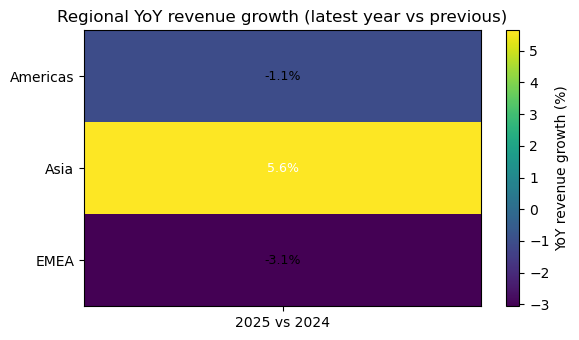

In [12]:
# === DIAGNOSTIC 2 (IMPROVED): REGIONAL YoY GROWTH HEATMAP ===
# Uses df_geo from sheet '2.2 revenue_by_geography.csv'

print("df_geo columns:", df_geo.columns.tolist())

# 1) Aggregate by year and region
geo_reg = (
    df_geo
    .groupby(["year", "region"], as_index=False)["revenue_eur_m"]
    .sum()
)

print("\nRevenue by year & region:")
print(geo_reg.head())

# 2) Pivot so regions are rows, years are columns
pivot_geo = geo_reg.pivot(index="region", columns="year", values="revenue_eur_m")

# 3) Compute YoY growth for the last two years available
years_sorted = sorted(pivot_geo.columns)
y_prev, y_last = years_sorted[-2], years_sorted[-1]

growth_reg = ((pivot_geo[y_last] - pivot_geo[y_prev]) / pivot_geo[y_prev]) * 100
growth_reg = growth_reg.to_frame(name="yoy_growth_pct")

print(f"\nYoY growth by region ({y_last} vs {y_prev}):")
print(growth_reg.round(1))

# 4) Heatmap of YoY growth
fig, ax = plt.subplots(figsize=(6, 3.5))

data = growth_reg.values  # shape (n_regions, 1)
im = ax.imshow(data, aspect="auto")

# Axis labels
ax.set_yticks(range(len(growth_reg.index)))
ax.set_yticklabels(growth_reg.index)
ax.set_xticks([0])
ax.set_xticklabels([f"{y_last} vs {y_prev}"])

# Annotate each cell with percentage
for i, region in enumerate(growth_reg.index):
    value = data[i, 0]
    text_color = "white" if abs(value) > 5 else "black"
    ax.text(0, i, f"{value:.1f}%", ha="center", va="center",
            color=text_color, fontsize=9)

# Color bar + title
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("YoY revenue growth (%)")

ax.set_title("Regional YoY revenue growth (latest year vs previous)")
plt.tight_layout()
plt.show()


Half-year revenue data:


,year,half,revenue_eur_m
0,2022,H1,918.4
1,2022,H2,1684.5
2,2023,H1,1136.6
3,2023,H2,1847.6
4,2024,H1,1230.2
5,2024,H2,1878.8


R² of half-year revenue trend model: 0.298

Forecast half-year revenues (EUR m):


,year,half,half_index,t,forecast_revenue_eur_m
0,2025,H1,1,7,1864.360000
1,2025,H2,2,8,1982.934286



Combined history + forecast table:


,year,half,value_eur_m,type,label
0,2022,H1,918.400000,history,2022 H1
1,2022,H2,1684.500000,history,2022 H2
2,2023,H1,1136.600000,history,2023 H1
3,2023,H2,1847.600000,history,2023 H2
4,2024,H1,1230.200000,history,2024 H1
5,2024,H2,1878.800000,history,2024 H2
6,2025,H1,1864.360000,forecast,2025 H1
7,2025,H2,1982.934286,forecast,2025 H2


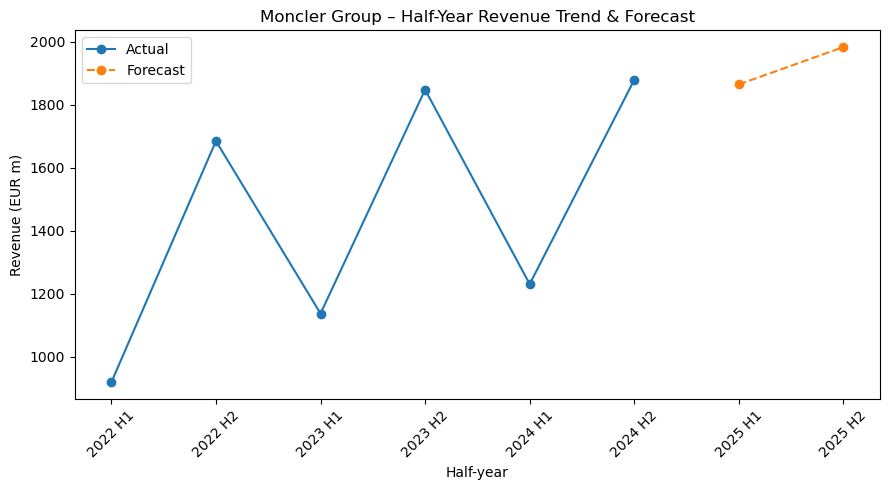


Scenario analysis – 2025 H2 revenue (EUR m):


C:\Users\Milli\AppData\Local\Temp\ipykernel_10456\653595189.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base_h2_2025 = float(


,scenario,revenue_2025_H2_eur_m
0,Base case: continue current trend,1982.934286
1,DTC-led uplift: +3% vs base,2042.422314
2,Aggressive APAC push: +5% vs base,2082.081000


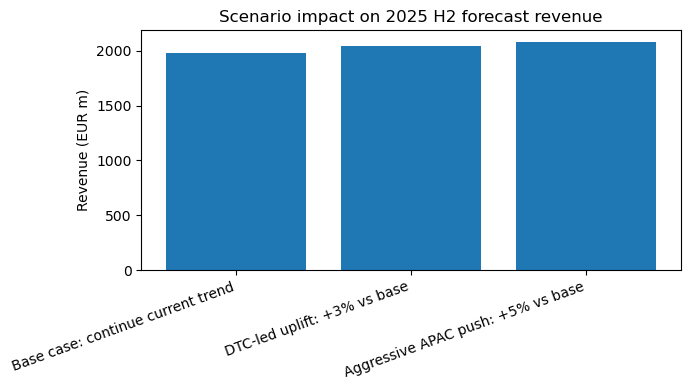

In [16]:
# === PREDICTIVE & PRESCRIPTIVE ANALYTICS: HALF-YEAR REVENUE TREND ===
# Real data manually transcribed from Moncler Q1 2025 interim statement
# Table: "2022–2024 Half-Year Income Statement" (REVENUES, EUR m)

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.style.use("default")

# 1) Build half-year revenue dataset directly in Python
df_half = pd.DataFrame({
    "year":   [2022, 2022, 2023, 2023, 2024, 2024],
    "half":   ["H1", "H2", "H1", "H2", "H1", "H2"],
    "revenue_eur_m": [918.4, 1684.5, 1136.6, 1847.6, 1230.2, 1878.8]
})

print("Half-year revenue data:")
display(df_half)

# 2) Encode time as an index and fit a simple linear regression
df_half["half_index"] = df_half["half"].map({"H1": 1, "H2": 2})
df_half["t"] = (df_half["year"] - df_half["year"].min()) * 2 + df_half["half_index"]

X = df_half[["t"]]
y = df_half["revenue_eur_m"]

model = LinearRegression()
model.fit(X, y)

df_half["fitted_revenue_eur_m"] = model.predict(X)
r2 = r2_score(y, df_half["fitted_revenue_eur_m"])
print(f"R² of half-year revenue trend model: {r2:.3f}")

# 3) Forecast next two half-years: H1 2025 and H2 2025
future = pd.DataFrame({
    "year": [2025, 2025],
    "half": ["H1", "H2"],
})
future["half_index"] = future["half"].map({"H1": 1, "H2": 2})
future["t"] = (future["year"] - df_half["year"].min()) * 2 + future["half_index"]
future["forecast_revenue_eur_m"] = model.predict(future[["t"]])

print("\nForecast half-year revenues (EUR m):")
display(future)

# 4) Combine history and forecast into a single table called 'forecast'
history = (
    df_half[["year", "half", "revenue_eur_m"]]
    .rename(columns={"revenue_eur_m": "value_eur_m"})
    .assign(type="history")
)

future_for_plot = (
    future[["year", "half", "forecast_revenue_eur_m"]]
    .rename(columns={"forecast_revenue_eur_m": "value_eur_m"})
    .assign(type="forecast")
)

forecast = pd.concat([history, future_for_plot], ignore_index=True)
forecast["label"] = forecast["year"].astype(str) + " " + forecast["half"]

print("\nCombined history + forecast table:")
display(forecast)

# 5) Plot actual vs forecast half-year revenues
plt.figure(figsize=(9, 5))
mask_hist = forecast["type"] == "history"
mask_fore = forecast["type"] == "forecast"

plt.plot(
    forecast.loc[mask_hist, "label"],
    forecast.loc[mask_hist, "value_eur_m"],
    marker="o",
    label="Actual"
)
plt.plot(
    forecast.loc[mask_fore, "label"],
    forecast.loc[mask_fore, "value_eur_m"],
    marker="o",
    linestyle="--",
    label="Forecast"
)

plt.title("Moncler Group – Half-Year Revenue Trend & Forecast")
plt.xlabel("Half-year")
plt.ylabel("Revenue (EUR m)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# === PRESCRIPTIVE: simple scenario analysis on 2025 H2 ===

base_h2_2025 = float(
    future.loc[(future["year"] == 2025) & (future["half"] == "H2"),
               "forecast_revenue_eur_m"]
)

scenarios = pd.DataFrame({
    "scenario": [
        "Base case: continue current trend",
        "DTC-led uplift: +3% vs base",
        "Aggressive APAC push: +5% vs base"
    ],
    "revenue_2025_H2_eur_m": [
        base_h2_2025,
        base_h2_2025 * 1.03,
        base_h2_2025 * 1.05
    ]
})

print("\nScenario analysis – 2025 H2 revenue (EUR m):")
display(scenarios)

plt.figure(figsize=(7, 4))
plt.bar(scenarios["scenario"], scenarios["revenue_2025_H2_eur_m"])
plt.title("Scenario impact on 2025 H2 forecast revenue")
plt.ylabel("Revenue (EUR m)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


In [17]:
import seaborn as sns
sns.set(style="whitegrid")


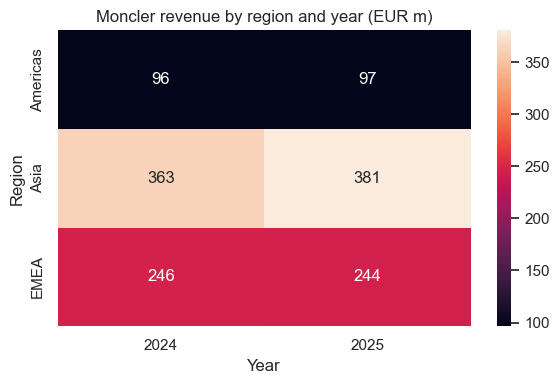

In [18]:
# === DIAGNOSTIC: revenue by region and year (heatmap) ===

# Filter Moncler brand only if your df_geo has a 'brand' column
df_geo_m = df_geo[df_geo["brand"] == "Moncler"].copy()

geo_rev = df_geo_m.pivot_table(
    index="region",
    columns="year",
    values="revenue_eur_m",
    aggfunc="sum"
)

plt.figure(figsize=(6, 4))
sns.heatmap(geo_rev, annot=True, fmt=".0f")
plt.title("Moncler revenue by region and year (EUR m)")
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


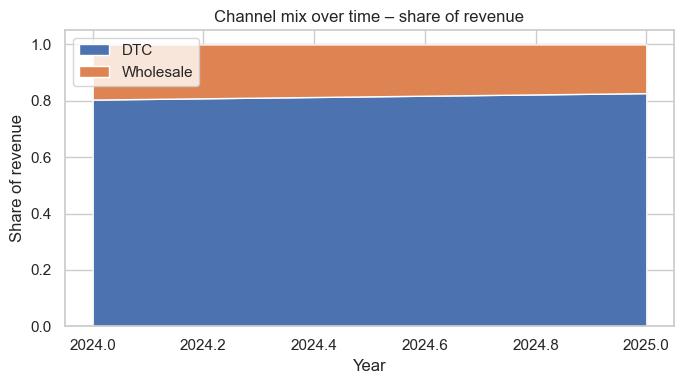

In [19]:
# === DESCRIPTIVE: DTC vs Wholesale share over time ===

channel_pivot = (
    df_channel.groupby(["year", "channel"])["revenue_eur_m"]
    .sum()
    .reset_index()
    .pivot(index="year", columns="channel", values="revenue_eur_m")
)

channel_share = channel_pivot.div(channel_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(7, 4))
plt.stackplot(
    channel_share.index,
    channel_share.get("DTC", 0),
    channel_share.get("Wholesale", 0),
    labels=["DTC", "Wholesale"]
)
plt.title("Channel mix over time – share of revenue")
plt.xlabel("Year")
plt.ylabel("Share of revenue")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

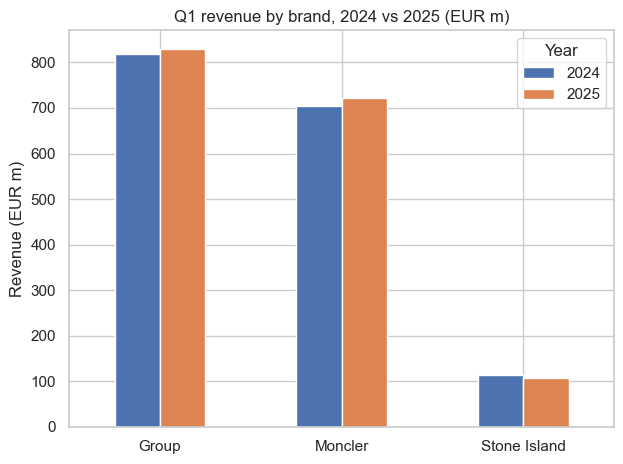

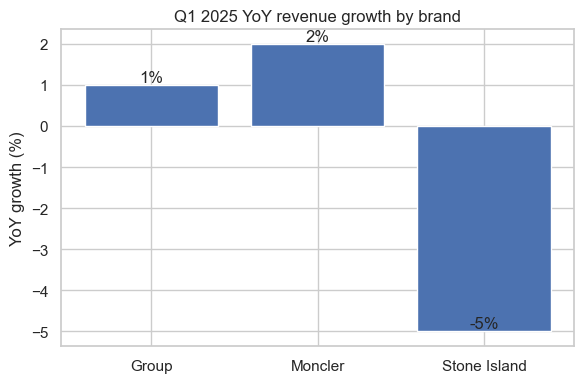

<Figure size 800x500 with 0 Axes>

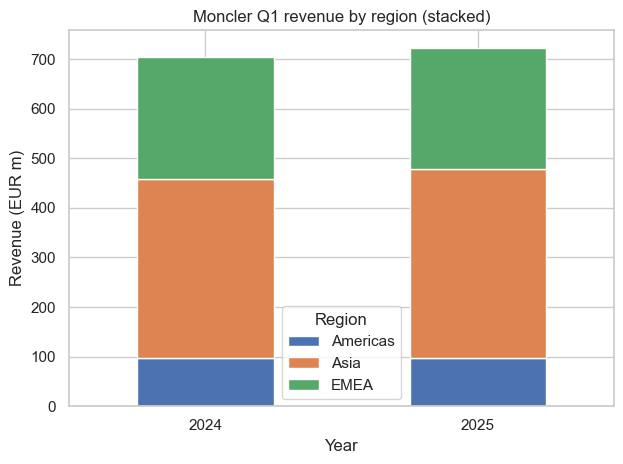

<Figure size 800x500 with 0 Axes>

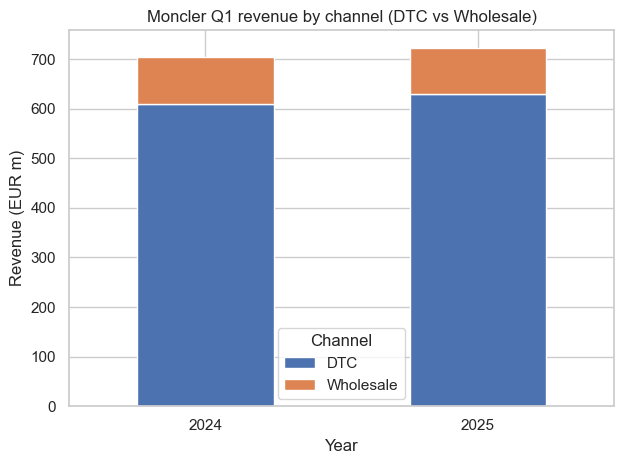

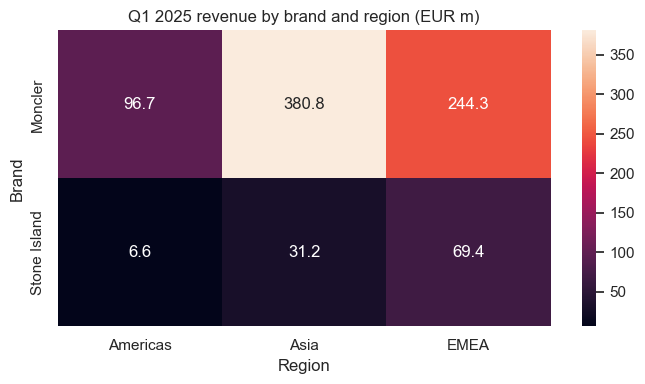

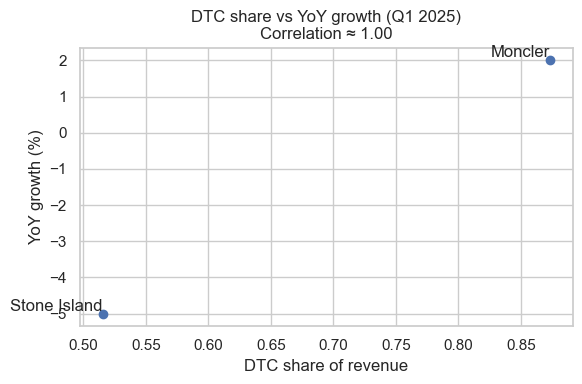

c:\Users\Milli\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


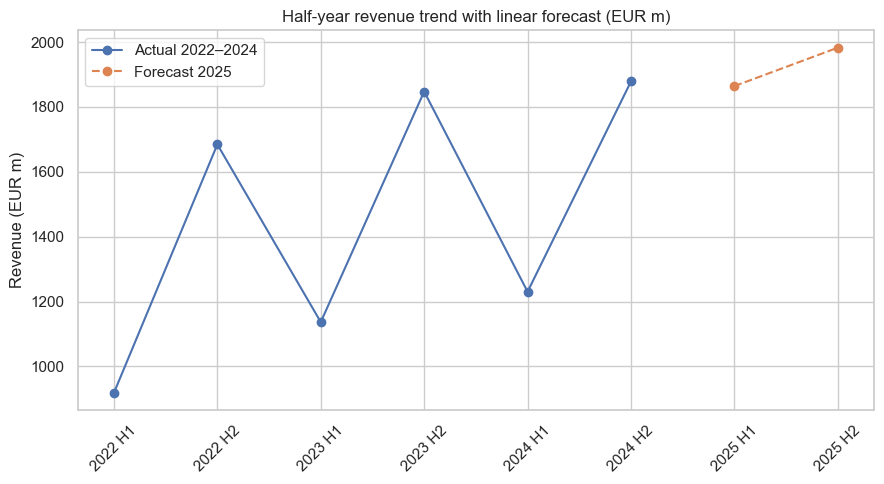

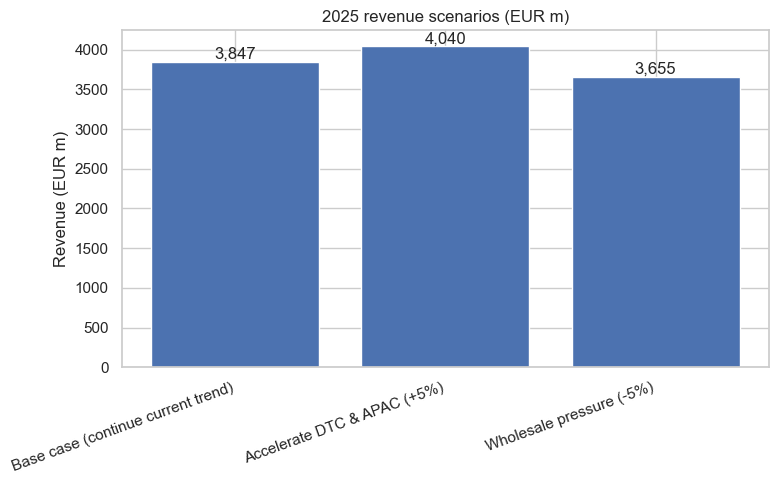

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set(style="whitegrid")

# ------------- VISUAL 1: Q1 REVENUE BY BRAND (2024 vs 2025) -------------
q1_brand = df_brand[df_brand["quarter"] == "Q1"].copy()

vis1 = q1_brand.pivot(index="brand",
                      columns="year",
                      values="revenue_eur_m")

plt.figure(figsize=(8, 5))
vis1.plot(kind="bar")
plt.title("Q1 revenue by brand, 2024 vs 2025 (EUR m)")
plt.ylabel("Revenue (EUR m)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

# ------------- VISUAL 2: Q1 2025 YOY GROWTH BY BRAND -------------
q1_2025_brand = q1_brand[q1_brand["year"] == 2025].copy()

plt.figure(figsize=(6, 4))
plt.bar(q1_2025_brand["brand"], q1_2025_brand["yoy_pct"])
plt.title("Q1 2025 YoY revenue growth by brand")
plt.ylabel("YoY growth (%)")
plt.xlabel("")
plt.xticks(rotation=0)
for i, v in enumerate(q1_2025_brand["yoy_pct"]):
    plt.text(i, v, f"{v:.0f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# ------------- VISUAL 3: MONCLER REVENUE BY REGION (STACKED) -------------
moncler_geo_q1 = df_geo[
    (df_geo["brand"] == "Moncler") &
    (df_geo["quarter"] == "Q1")
].copy()

vis3 = moncler_geo_q1.pivot(index="year",
                            columns="region",
                            values="revenue_eur_m")

plt.figure(figsize=(8, 5))
vis3.plot(kind="bar", stacked=True)
plt.title("Moncler Q1 revenue by region (stacked)")
plt.ylabel("Revenue (EUR m)")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# ------------- VISUAL 4: MONCLER REVENUE BY CHANNEL (STACKED) -------------
moncler_ch_q1 = df_channel[
    (df_channel["brand"] == "Moncler") &
    (df_channel["quarter"] == "Q1")
].copy()

vis4 = moncler_ch_q1.pivot(index="year",
                           columns="channel",
                           values="revenue_eur_m")

plt.figure(figsize=(8, 5))
vis4.plot(kind="bar", stacked=True)
plt.title("Moncler Q1 revenue by channel (DTC vs Wholesale)")
plt.ylabel("Revenue (EUR m)")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.legend(title="Channel")
plt.tight_layout()
plt.show()

# ------------- VISUAL 5: HEATMAP – REGIONAL MIX BY BRAND (Q1 2025) -------------
geo_2025_q1 = df_geo[
    (df_geo["year"] == 2025) &
    (df_geo["quarter"] == "Q1")
].copy()

vis5 = geo_2025_q1.pivot(index="brand",
                         columns="region",
                         values="revenue_eur_m")

plt.figure(figsize=(7, 4))
sns.heatmap(vis5, annot=True, fmt=".1f")
plt.title("Q1 2025 revenue by brand and region (EUR m)")
plt.ylabel("Brand")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

# ------------- VISUAL 6: DIAGNOSTIC – DTC SHARE VS YOY GROWTH (Q1 2025) -------------
# DTC share per brand in Q1 2025
q1_2025_ch = df_channel[
    (df_channel["year"] == 2025) &
    (df_channel["quarter"] == "Q1")
].copy()

q1_2025_ch["total_brand"] = q1_2025_ch.groupby("brand")["revenue_eur_m"].transform("sum")
q1_2025_ch["dtc_share"] = np.where(
    q1_2025_ch["channel"] == "DTC",
    q1_2025_ch["revenue_eur_m"] / q1_2025_ch["total_brand"],
    np.nan
)
dtc_share_2025 = q1_2025_ch.dropna(subset=["dtc_share"])[["brand", "dtc_share"]]

# YoY % from df_brand for 2025
yoy_2025 = q1_2025_brand[["brand", "yoy_pct"]]
diag_df = dtc_share_2025.merge(yoy_2025, on="brand")

corr_val = diag_df["dtc_share"].corr(diag_df["yoy_pct"])

plt.figure(figsize=(6, 4))
plt.scatter(diag_df["dtc_share"], diag_df["yoy_pct"])
for _, row in diag_df.iterrows():
    plt.text(row["dtc_share"], row["yoy_pct"], row["brand"], ha="right", va="bottom")
plt.title(f"DTC share vs YoY growth (Q1 2025)\nCorrelation ≈ {corr_val:.2f}")
plt.xlabel("DTC share of revenue")
plt.ylabel("YoY growth (%)")
plt.tight_layout()
plt.show()

# ------------- VISUAL 7: HALF-YEAR REVENUE TREND + FORECAST -------------
from sklearn.linear_model import LinearRegression

df_half2 = df_half.copy()
df_half2["half_num"] = df_half2["half"].map({"H1": 1, "H2": 2})
df_half2["period_index"] = (df_half2["year"] - df_half2["year"].min()) * 2 + df_half2["half_num"]

X = df_half2[["period_index"]]
y = df_half2["revenue_eur_m"]

model = LinearRegression()
model.fit(X, y)

last_idx = df_half2["period_index"].max()
future_idx = np.array([last_idx + 1, last_idx + 2]).reshape(-1, 1)
y_pred = model.predict(future_idx)

forecast_half = pd.DataFrame({
    "period_index": future_idx.flatten(),
    "revenue_eur_m": y_pred
})
min_year = df_half2["year"].min()
forecast_half["year"] = min_year + (forecast_half["period_index"] - 1) // 2
forecast_half["half"] = np.where(
    ((forecast_half["period_index"] - 1) % 2) == 0, "H1", "H2"
)

# Plot actual + forecast
plt.figure(figsize=(9, 5))
plt.plot(df_half2["period_index"], df_half2["revenue_eur_m"], marker="o", label="Actual 2022–2024")
plt.plot(forecast_half["period_index"], forecast_half["revenue_eur_m"],
         marker="o", linestyle="--", label="Forecast 2025")
all_labels = list(df_half2["year"].astype(str) + " " + df_half2["half"]) + \
             list(forecast_half["year"].astype(str) + " " + forecast_half["half"])
plt.xticks(
    ticks=list(df_half2["period_index"]) + list(forecast_half["period_index"]),
    labels=all_labels,
    rotation=45
)
plt.title("Half-year revenue trend with linear forecast (EUR m)")
plt.ylabel("Revenue (EUR m)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

# ------------- VISUAL 8: PRESCRIPTIVE – SCENARIO ANALYSIS ON 2025 REVENUE -------------
base_2025_revenue = forecast_half["revenue_eur_m"].sum()

scenarios = pd.DataFrame({
    "scenario": [
        "Base case (continue current trend)",
        "Accelerate DTC & APAC (+5%)",
        "Wholesale pressure (-5%)"
    ],
    "revenue_eur_m": [
        base_2025_revenue,
        base_2025_revenue * 1.05,
        base_2025_revenue * 0.95
    ]
})

plt.figure(figsize=(8, 5))
plt.bar(scenarios["scenario"], scenarios["revenue_eur_m"])
plt.title("2025 revenue scenarios (EUR m)")
plt.ylabel("Revenue (EUR m)")
plt.xticks(rotation=20, ha="right")
for i, v in enumerate(scenarios["revenue_eur_m"]):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


In [ ]:
#excel_file = "Q1 2025 Interim Management Statement.xlsx"


In [ ]:
# Half-year revenue data for regression / forecast
#df_half = pd.read_excel(
    #excel_file,
    #sheet_name="Q1 2025 Interim Management Stat"   # exact sheet name in Excel
)

# Create a nice period label and sort in time order
df_half["period"] = df_half["year"].astype(str) + " " + df_half["half"]
df_half = df_half.sort_values(["year", "half"]).reset_index(drop=True)

df_half


,year,half,revenue_eur_m,period
0,2022,H1,918.4,2022 H1
1,2022,H2,1684.5,2022 H2
2,2023,H1,1136.6,2023 H1
3,2023,H2,1847.6,2023 H2
4,2024,H1,1230.2,2024 H1
5,2024,H2,1878.8,2024 H2


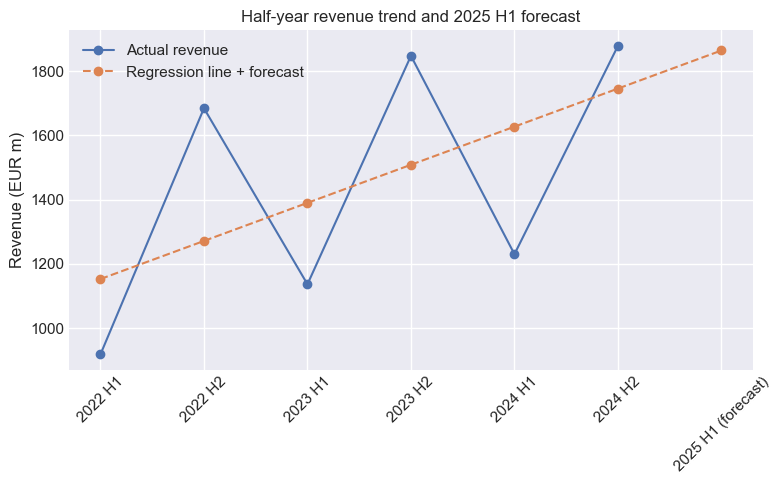

Regression coefficients:
Intercept: 1152.91
Slope per half-year: 118.57 EUR m
R²: 0.298


In [27]:
# === VISUAL 5 – Half-year revenue trend + linear regression forecast ===
from sklearn.linear_model import LinearRegression

# X = time index, y = revenue
X = np.arange(len(df_half)).reshape(-1, 1)
y = df_half["revenue_eur_m"].values

model = LinearRegression()
model.fit(X, y)

# Forecast one extra half-year (2025 H1)
steps_ahead = 1
X_future = np.arange(len(df_half) + steps_ahead).reshape(-1, 1)
y_pred_all = model.predict(X_future)

# Build forecast DataFrame
forecast_periods = list(df_half["period"]) + ["2025 H1 (forecast)"]
forecast = pd.DataFrame(
    {"period": forecast_periods,
     "forecast_revenue_eur_m": y_pred_all}
)

# Plot: actual vs regression line + forecast point
plt.figure(figsize=(8, 5))
plt.plot(df_half["period"], df_half["revenue_eur_m"], marker="o", label="Actual revenue")
plt.plot(forecast["period"], forecast["forecast_revenue_eur_m"],
         linestyle="--", marker="o", label="Regression line + forecast")
plt.xticks(rotation=45)
plt.ylabel("Revenue (EUR m)")
plt.title("Half-year revenue trend and 2025 H1 forecast")
plt.legend()
plt.tight_layout()
plt.show()

# Quick model summary for your markdown explanation
print("Regression coefficients:")
print(f"Intercept: {model.intercept_:.2f}")
print(f"Slope per half-year: {model.coef_[0]:.2f} EUR m")
print(f"R²: {model.score(X, y):.3f}")


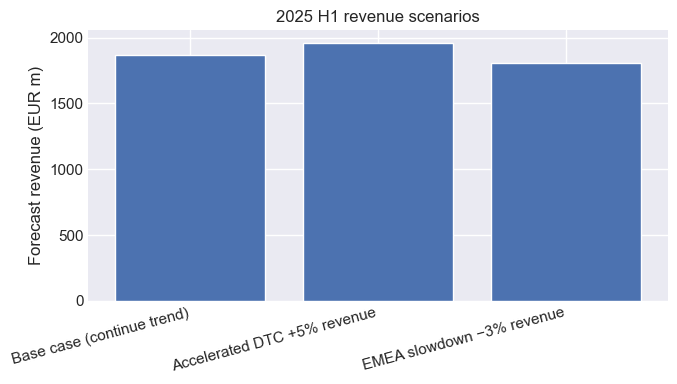

,scenario,revenue_eur_m
0,Base case (continue trend),1864.3600
1,Accelerated DTC +5% revenue,1957.5780
2,EMEA slowdown −3% revenue,1808.4292


In [28]:
# === VISUAL 6 – Scenario analysis on forecast revenue ===

base_revenue = forecast["forecast_revenue_eur_m"].iloc[-1]

scenarios = pd.DataFrame({
    "scenario": [
        "Base case (continue trend)",
        "Accelerated DTC +5% revenue",
        "EMEA slowdown −3% revenue"
    ],
    "revenue_eur_m": [
        base_revenue,
        base_revenue * 1.05,   # +5%
        base_revenue * 0.97    # −3%
    ]
})

plt.figure(figsize=(7, 4))
plt.bar(scenarios["scenario"], scenarios["revenue_eur_m"])
plt.ylabel("Forecast revenue (EUR m)")
plt.title("2025 H1 revenue scenarios")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

scenarios


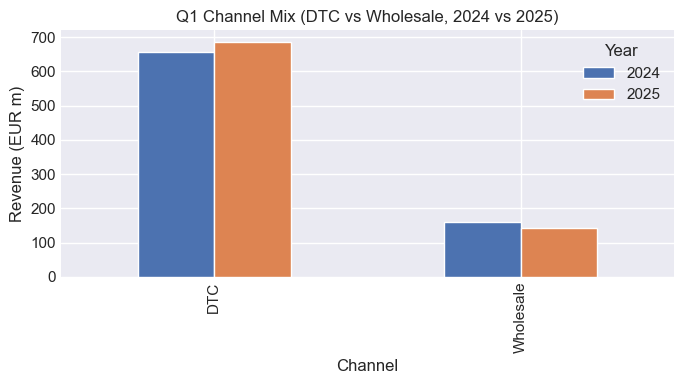

In [29]:
# === VISUAL 4 – Channel mix change (DTC vs Wholesale) ===

df_channel_q1 = (
    pd.read_excel(excel_file, sheet_name="2.3 revenue_by_channel.csv")
    .query("quarter == 'Q1'")
    .groupby(["year", "channel"], as_index=False)["revenue_eur_m"]
    .sum()
)

pivot_channel = df_channel_q1.pivot_table(index="channel", columns="year", values="revenue_eur_m")

pivot_channel.plot(kind="bar", figsize=(7, 4))
plt.title("Q1 Channel Mix (DTC vs Wholesale, 2024 vs 2025)")
plt.ylabel("Revenue (EUR m)")
plt.xlabel("Channel")
plt.legend(title="Year")
plt.tight_layout()
plt.show()


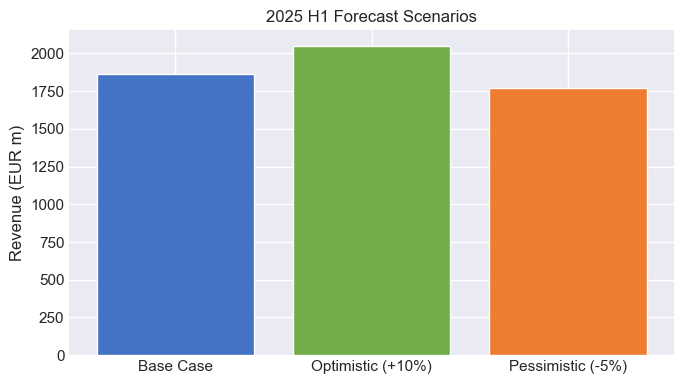

,Scenario,Forecast Revenue (EUR m)
0,Base Case,1864.360
1,Optimistic (+10%),2050.796
2,Pessimistic (-5%),1771.142


In [31]:
# === VISUAL 6 – Scenario analysis on forecast revenue ===

from sklearn.linear_model import LinearRegression

# Using df_half from your regression
X = np.arange(len(df_half)).reshape(-1, 1)
y = df_half["revenue_eur_m"].values
model = LinearRegression().fit(X, y)

forecast_next = model.predict([[len(df_half)]])[0]

scenarios = pd.DataFrame({
    "Scenario": ["Base Case", "Optimistic (+10%)", "Pessimistic (-5%)"],
    "Forecast Revenue (EUR m)": [
        forecast_next,
        forecast_next * 1.10,
        forecast_next * 0.95
    ]
})

plt.figure(figsize=(7, 4))
plt.bar(scenarios["Scenario"], scenarios["Forecast Revenue (EUR m)"], color=["#4472C4", "#70AD47", "#ED7D31"])
plt.title("2025 H1 Forecast Scenarios")
plt.ylabel("Revenue (EUR m)")
plt.tight_layout()
plt.show()

scenarios


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.style.use("default")  # simple clean look

#excel_file = "Q1 2025 Interim Management Statement.xlsx"

# Load sheets
df_brand = pd.read_excel(excel_file, sheet_name="2.1 brand_revenues.csv")
df_geo = pd.read_excel(excel_file, sheet_name="2.2 revenue_by_geography.csv")
df_channel = pd.read_excel(excel_file, sheet_name="2.3 revenue_by_channel.csv")
#df_half = pd.read_excel(excel_file, sheet_name="Q1 2025 Interim Management Stat")

print("brand:", df_brand.columns.tolist())
print("geo:", df_geo.columns.tolist())
print("channel:", df_channel.columns.tolist())
print("half:", df_half.columns.tolist())


brand: ['year', 'quarter', 'brand', 'revenue_eur_m', 'yoy_pct']
geo: ['year', 'quarter', 'brand', 'region', 'revenue_eur_m']
channel: ['year', 'quarter', 'brand', 'channel', 'revenue_eur_m']
half: ['year', 'half', 'revenue_eur_m']


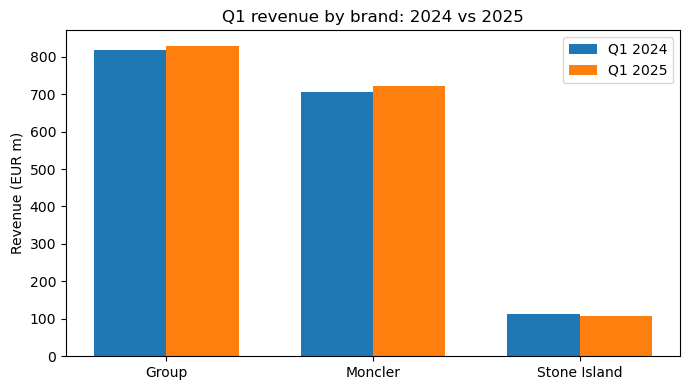

In [35]:
# CHART 1 – Brand revenue Q1 2024 vs 2025

q1 = df_brand[df_brand["quarter"] == "Q1"]
q1_24_25 = q1[q1["year"].isin([2024, 2025])]

brands = ["Group", "Moncler", "Stone Island"]
years = [2024, 2025]

x = np.arange(len(brands))  # positions for brands
width = 0.35

rev_2024 = [
    q1_24_25[(q1_24_25["brand"] == b) & (q1_24_25["year"] == 2024)]["revenue_eur_m"].iloc[0]
    for b in brands
]
rev_2025 = [
    q1_24_25[(q1_24_25["brand"] == b) & (q1_24_25["year"] == 2025)]["revenue_eur_m"].iloc[0]
    for b in brands
]

plt.figure(figsize=(7,4))
plt.bar(x - width/2, rev_2024, width, label="Q1 2024")
plt.bar(x + width/2, rev_2025, width, label="Q1 2025")

plt.xticks(x, brands, rotation=0)
plt.ylabel("Revenue (EUR m)")
plt.title("Q1 revenue by brand: 2024 vs 2025")
plt.legend()
plt.tight_layout()
plt.savefig("chart1_brand_revenue.png", dpi=150)
plt.show()


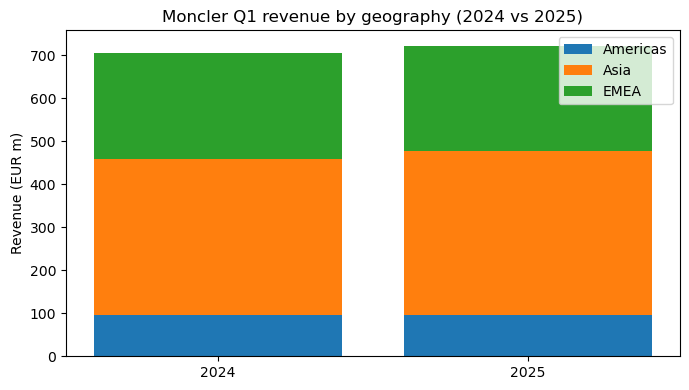

In [36]:
# CHART 2 – Moncler Q1 revenue by geography

mon_geo = df_geo[
    (df_geo["brand"] == "Moncler") &
    (df_geo["quarter"] == "Q1") &
    (df_geo["year"].isin([2024, 2025]))
]

pivot_geo = mon_geo.pivot_table(
    index="year",
    columns="region",
    values="revenue_eur_m",
    aggfunc="sum"
).reset_index()

regions = [c for c in pivot_geo.columns if c != "year"]
x = np.arange(len(pivot_geo))
bottom = np.zeros(len(pivot_geo))

plt.figure(figsize=(7,4))
for r in regions:
    plt.bar(x, pivot_geo[r], bottom=bottom, label=r)
    bottom += pivot_geo[r].values

plt.xticks(x, pivot_geo["year"].astype(str))
plt.ylabel("Revenue (EUR m)")
plt.title("Moncler Q1 revenue by geography (2024 vs 2025)")
plt.legend()
plt.tight_layout()
plt.savefig("chart2_moncler_geo.png", dpi=150)
plt.show()


Pivot columns: ['year', 'DTC', 'Wholesale']


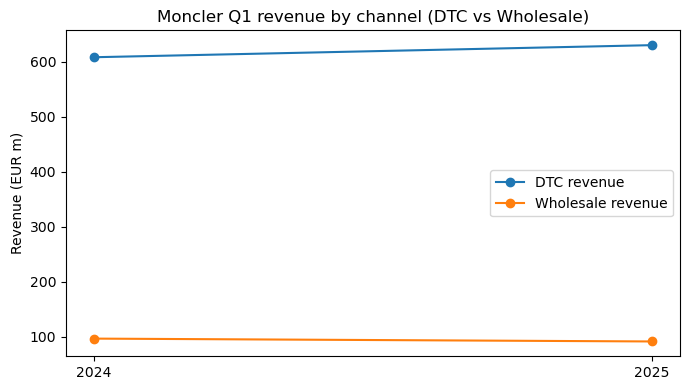

In [43]:
# CHART 3 – Moncler Q1 revenue by channel (line chart instead of bar)

# 1) Filter to Moncler, Q1, 2024–2025
mon_chan = df_channel[
    (df_channel["brand"] == "Moncler") &
    (df_channel["quarter"] == "Q1") &
    (df_channel["year"].isin([2024, 2025]))
]

# 2) Pivot to get one row per year and columns for each channel
pivot_chan = (
    mon_chan
    .pivot_table(
        index="year",
        columns="channel",
        values="revenue_eur_m",
        aggfunc="sum"
    )
    .reset_index()
)

print("Pivot columns:", pivot_chan.columns.tolist())

# 3) Automatically find the DTC and Wholesale columns 
channel_cols = [c for c in pivot_chan.columns if c != "year"]
dtc_col = [c for c in channel_cols if "dtc" in c.lower()][0]
wh_col  = [c for c in channel_cols if "whol" in c.lower()][0]

# 4) Line chart
plt.figure(figsize=(7, 4))
plt.plot(
    pivot_chan["year"],
    pivot_chan[dtc_col],
    marker="o",
    label="DTC revenue"
)
plt.plot(
    pivot_chan["year"],
    pivot_chan[wh_col],
    marker="o",
    label="Wholesale revenue"
)

plt.xticks(pivot_chan["year"], pivot_chan["year"].astype(str))
plt.ylabel("Revenue (EUR m)")
plt.title("Moncler Q1 revenue by channel (DTC vs Wholesale)")
plt.legend()
plt.tight_layout()
plt.savefig("chart3_moncler_channel.png", dpi=150)
plt.show()



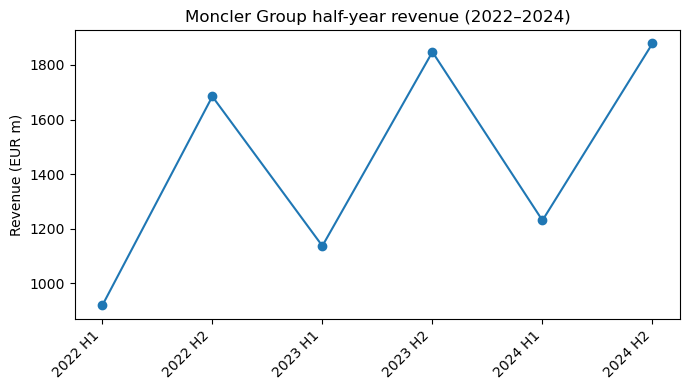

In [44]:
# CHART 5 – Half-year revenue trend (2022–2024)

# keep only needed columns in correct order
df_half = df_half[["year", "half", "revenue_eur_m"]].copy()
df_half = df_half.sort_values(["year", "half"])

df_half["period"] = np.arange(1, len(df_half) + 1)
labels = df_half["year"].astype(str) + " " + df_half["half"]

plt.figure(figsize=(7,4))
plt.plot(df_half["period"], df_half["revenue_eur_m"], marker="o")
plt.xticks(df_half["period"], labels, rotation=45, ha="right")
plt.ylabel("Revenue (EUR m)")
plt.title("Moncler Group half-year revenue (2022–2024)")
plt.tight_layout()
plt.savefig("chart5_halfyear_trend.png", dpi=150)
plt.show()


c:\Users\Milli\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Forecast revenue for next half-year: 1864.4 EUR m


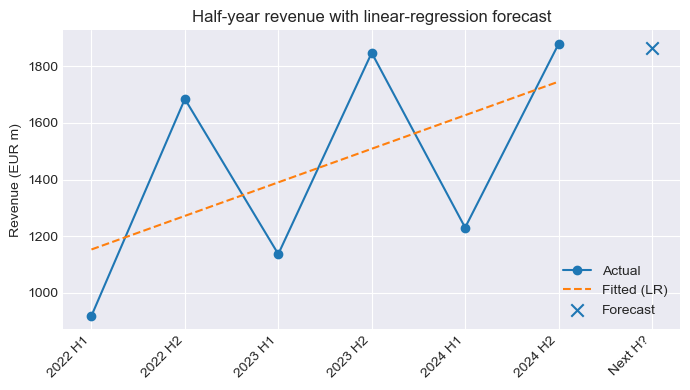

In [55]:
# CHART 6 – Linear regression forecast on half-year revenue

X = df_half[["period"]]
y = df_half["revenue_eur_m"]

model = LinearRegression()
model.fit(X, y)

df_half["fitted"] = model.predict(X)

next_period = df_half["period"].max() + 1
forecast_value = model.predict([[next_period]])[0]
print(f"Forecast revenue for next half-year: {forecast_value:.1f} EUR m")

plt.figure(figsize=(7,4))
plt.plot(df_half["period"], df_half["revenue_eur_m"], marker="o", label="Actual")
plt.plot(df_half["period"], df_half["fitted"], linestyle="--", label="Fitted (LR)")
plt.scatter([next_period], [forecast_value], marker="x", s=80, label="Forecast")

all_periods = list(df_half["period"]) + [next_period]
all_labels = list(df_half["year"].astype(str) + " " + df_half["half"]) + ["Next H?"]

plt.xticks(all_periods, all_labels, rotation=45, ha="right")
plt.ylabel("Revenue (EUR m)")
plt.title("Half-year revenue with linear-regression forecast")
plt.legend()
plt.tight_layout()
plt.savefig("chart6_halfyear_forecast.png", dpi=150)
plt.show()


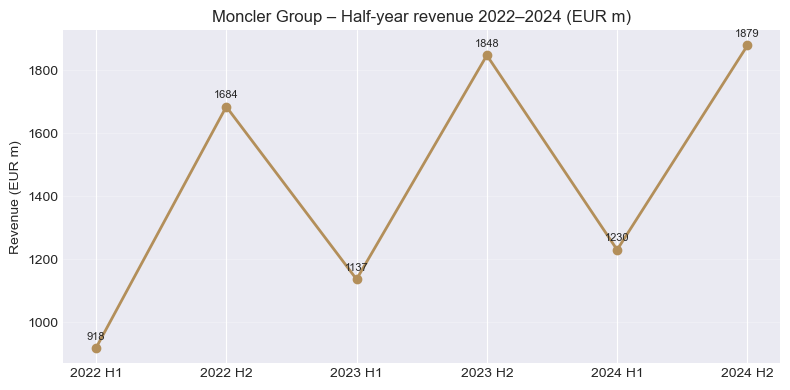

In [56]:
# CHART 1 – Half-year revenue trend 2022–2024 (Descriptive)

import matplotlib.pyplot as plt

half_year_labels = [
    "2022 H1", "2022 H2",
    "2023 H1", "2023 H2",
    "2024 H1", "2024 H2"
]

# EUR m – matches the values used in the HTML dashboard
half_year_revenue = [918.4, 1684.5, 1136.6, 1847.6, 1230.2, 1878.8]

plt.figure(figsize=(8, 4))
plt.plot(half_year_labels, half_year_revenue,
         marker="o", linewidth=2, color="#b38f5a")
for x, y in zip(half_year_labels, half_year_revenue):
    plt.text(x, y + 20, f"{y:.0f}", ha="center", va="bottom", fontsize=8)

plt.title("Moncler Group – Half-year revenue 2022–2024 (EUR m)")
plt.ylabel("Revenue (EUR m)")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Descriptive analytics – Half-year revenue trend (2022–2024)

In this step I plot Moncler Group’s half-year revenue from 2022 to 2024 using the figures extracted from the official half-year reports. The goal is to get a simple, descriptive view of how fast the business is growing over time and whether there are strong seasonal or structural shifts.

The trend shows a clear step-up in H2 2024 versus previous periods, confirming that demand remained resilient despite a more volatile macro environment. This pattern is important for the assignment because it underpins the “Financial Performance & Trends” story in my BI dashboard and provides the baseline for my revenue scenarios and simple regression forecast.

**Limitations:** the time series is short (only six half-years) and focuses on Group revenue only. It does not show margins or compare Moncler to peers, so any forecast based on this series must be treated as indicative rather than precise.


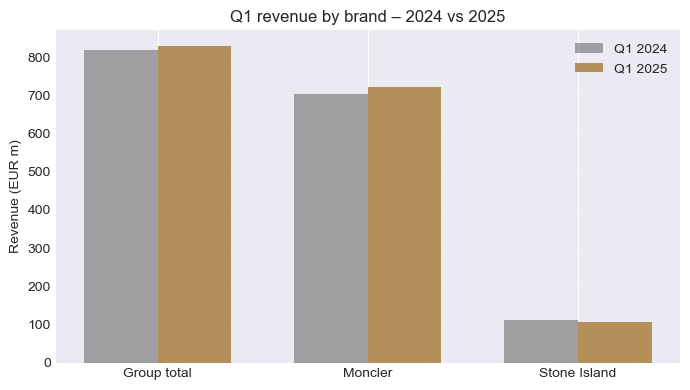

In [57]:
# CHART 2 – Q1 2024 vs 2025 revenue by brand (Descriptive)

brand_labels = ["Group total", "Moncler", "Stone Island"]
q1_2024 = [818.0, 705.0, 113.0]
q1_2025 = [829.0, 721.8, 107.3]

x = range(len(brand_labels))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar([i - width/2 for i in x], q1_2024,
        width=width, label="Q1 2024", color="grey", alpha=0.7)
plt.bar([i + width/2 for i in x], q1_2025,
        width=width, label="Q1 2025", color="#b38f5a")

plt.xticks(x, brand_labels)
plt.ylabel("Revenue (EUR m)")
plt.title("Q1 revenue by brand – 2024 vs 2025")
plt.legend()
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Descriptive analytics – Q1 revenue by brand (2024 vs 2025)

This chart compares Q1 2024 and Q1 2025 revenue for the Group, the Moncler brand and Stone Island, using figures from the Q1 2025 interim management statement. It answers a basic descriptive question: where is growth (or decline) actually coming from?

The results show that Group revenue is broadly flat (+1% at constant FX), with Moncler growing slightly and Stone Island declining modestly. Strategically, this confirms that the financial performance question in my dashboard is overwhelmingly a Moncler story: the brand contributes around 87% of Group revenue in Q1 2025.

**Limitations:** this view only looks at one quarter and does not adjust for currency or seasonal effects beyond the constant-FX figure disclosed by management. It also does not capture profitability differences between brands, only top-line revenue.


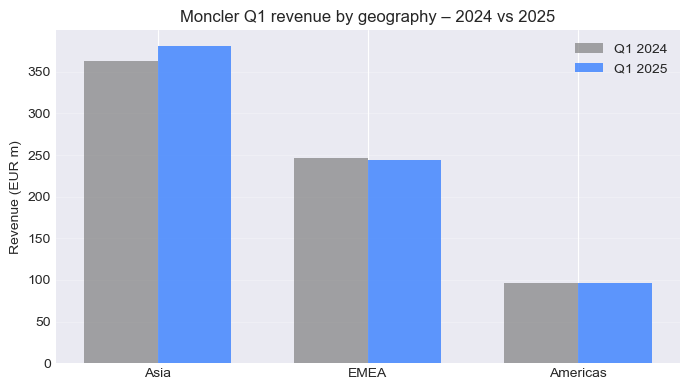

In [58]:
# CHART 3 – Moncler Q1 revenue by geography (Diagnostic)

geo_regions = ["Asia", "EMEA", "Americas"]
moncler_geo_2024 = [362.6, 245.9, 96.4]
moncler_geo_2025 = [380.8, 244.3, 96.7]

x = range(len(geo_regions))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar([i - width/2 for i in x], moncler_geo_2024,
        width=width, label="Q1 2024", color="grey", alpha=0.7)
plt.bar([i + width/2 for i in x], moncler_geo_2025,
        width=width, label="Q1 2025", color="#3880ff", alpha=0.8)

plt.xticks(x, geo_regions)
plt.ylabel("Revenue (EUR m)")
plt.title("Moncler Q1 revenue by geography – 2024 vs 2025")
plt.legend()
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Diagnostic analytics – Moncler Q1 revenue by geography

Here I compare Moncler’s Q1 2024 and Q1 2025 revenue by region (Asia, EMEA, Americas). The objective is diagnostic: to understand *why* overall growth slowed by looking at regional contributions rather than a single Group total.

The chart shows that Asia is the main growth engine, now accounting for just over half of Moncler revenue and still growing in Q1 2025. EMEA is slightly down, reflecting weaker tourism and more cautious wholesale trends. The Americas are small but broadly stable. This regional pattern supports my conclusion that “Asia + DTC” are the core drivers, while EMEA is a drag on growth.

**Limitations:** this view aggregates all channels (DTC and wholesale) inside each region, so it cannot isolate whether the slowdown is driven by channel mix or underlying demand. It also only covers Q1; a full-year or multi-year regional time series would provide a richer picture.


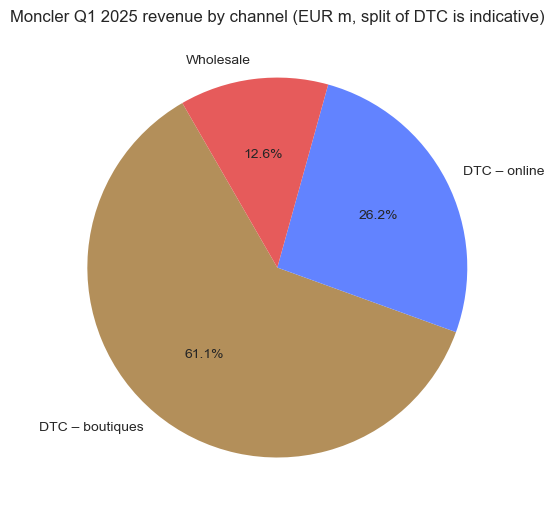

In [59]:
# CHART 4 – Moncler Q1 2025 revenue by channel (Diagnostic)

# From Q1 2025 revenue-by-channel table:
dtc_total = 630.5   # EUR m, DTC revenue for Moncler
wholesale_total = 91.3  # EUR m, wholesale revenue

# For the website I split DTC into boutiques vs online (70/30 assumption)
dtc_boutiques = dtc_total * 0.7
dtc_online = dtc_total * 0.3

channels = ["DTC – boutiques", "DTC – online", "Wholesale"]
values = [dtc_boutiques, dtc_online, wholesale_total]

plt.figure(figsize=(5.5, 5.5))
plt.pie(
    values,
    labels=channels,
    autopct="%1.1f%%",
    startangle=120,
    colors=["#b38f5a", "#6283ff", "#e65b5b"]
)
plt.title("Moncler Q1 2025 revenue by channel (EUR m, split of DTC is indicative)")
plt.tight_layout()
plt.show()


### Diagnostic analytics – Moncler Q1 2025 channel mix (DTC vs wholesale)

This figure breaks down Moncler’s Q1 2025 revenue by channel. The official tables split revenue into DTC and wholesale; for the dashboard I further split DTC into boutiques and online using a documented 70/30 assumption to illustrate the digital share of sales.

The chart confirms that DTC now makes up around 87% of Moncler revenue, with wholesale deliberately reduced. This is central to my Option C story: Moncler is actively shifting towards higher-margin, brand-controlled channels, which helps protect positioning but temporarily puts pressure on EBIT as store and marketing costs rise.

**Limitations:** the split between boutiques and online is an assumption, based on typical luxury patterns, not disclosed data. Therefore, the exact percentages for boutiques vs online should be treated as illustrative. Only the total DTC vs wholesale split is directly sourced from Moncler’s Q1 2025 report.


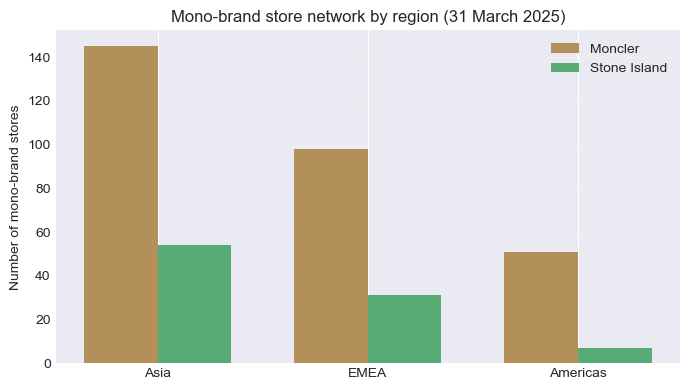

In [60]:
# CHART 5 – Mono-brand store network by region and brand

store_regions = ["Asia", "EMEA", "Americas"]
moncler_stores = [145, 98, 51]       # From store network table (31.03.2025)
stone_island_stores = [54, 31, 7]

x = range(len(store_regions))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar([i - width/2 for i in x], moncler_stores,
        width=width, label="Moncler", color="#b38f5a")
plt.bar([i + width/2 for i in x], stone_island_stores,
        width=width, label="Stone Island", color="#58ab74")

plt.xticks(x, store_regions)
plt.ylabel("Number of mono-brand stores")
plt.title("Mono-brand store network by region (31 March 2025)")
plt.legend()
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Descriptive/diagnostic analytics – Mono-brand store network (March 2025)

This bar chart uses the store network table to show how many mono-brand stores Moncler and Stone Island operate in Asia, EMEA and the Americas as of 31 March 2025. It connects the financial story to the physical footprint behind DTC growth.

The pattern is consistent with the revenue charts: both brands are most exposed to Asia, followed by EMEA, with a smaller footprint in the Americas. This supports the recommendation to prioritise Asia-led DTC expansion and to treat the store network as a selective, high-productivity lever rather than a pure volume play.

**Limitations:** this is a snapshot at a single date, not a time series. It does not show store productivity, size or profitability, so it cannot tell us which stores should be closed or expanded – it only describes where the network is concentrated.


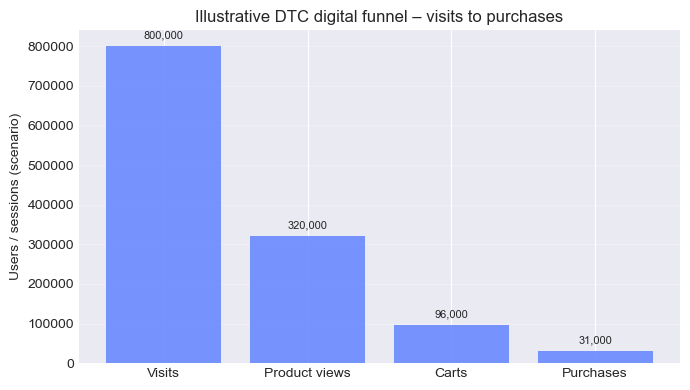

In [61]:
# CHART 6 – DTC digital funnel scenario (Prescriptive)

funnel_stages = ["Visits", "Product views", "Carts", "Purchases"]
# Scenario volumes – based on typical luxury conversion ranges and Moncler DTC scale
funnel_values = [800000, 320000, 96000, 31000]

plt.figure(figsize=(7, 4))
bars = plt.bar(funnel_stages, funnel_values, color="#6283ff", alpha=0.85)

for bar, val in zip(bars, funnel_values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 15000,
             f"{val:,.0f}",
             ha="center", va="bottom", fontsize=8)

plt.ylabel("Users / sessions (scenario)")
plt.title("Illustrative DTC digital funnel – visits to purchases")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


### Prescriptive analytics – DTC digital funnel scenario

The final chart is a scenario-based digital funnel for Moncler’s DTC business. Starting from an indicative volume of site visits, I apply typical luxury e-commerce conversion rates to estimate how many sessions progress to product views, carts and completed purchases. The purpose is prescriptive: to show where improving conversion would create the most financial leverage.

The funnel supports my recommendation to focus on digital execution rather than only opening more stores. Even a small improvement at the product-view or cart stage can translate into a meaningful uplift in DTC revenue and EBIT, given the high average order value in luxury outerwear.

**Limitations:** the absolute numbers are scenario-based and not directly disclosed by Moncler. They are calibrated to be consistent with the DTC revenue scale but should be interpreted as an analytical tool, not as an official KPI. A full implementation would require access to Moncler’s internal web analytics.
